In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    concatenate,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [3]:
# --- Load and Initial Processing (Similar to your code) ---
data = pd.read_csv(f"sports-miner.fbref.2.csv")
data["date"] = pd.to_datetime(data["date"], dayfirst=True, unit="ms")
data.sort_values(by="date", inplace=True) # Ensure data is sorted early

# --- Create Home/Away Stats (Slightly simplified feature set for LSTM start) ---
# Select features that represent a single game's performance
# Avoid rolling averages here initially
base_features = [
    "date",
    "season",
    "league",
    "home_team",
    "away_team",
    "stats.score_home",
    "stats.score_away",
    "stats.shots_home",
    "stats.shots_away",
    "stats.shots_on_target_home",
    "stats.shots_on_target_away",
    "stats.possesion_home",
    "stats.possesion_away",
    "stats.passes_completed_home",
    "stats.passes_completed_away",
    "stats.fouls_home",
    "stats.fouls_away",
    "stats.corners_home",
    "stats.corners_away",
    "stats.cards_yellow_home",
    "stats.cards_yellow_away",
    "stats.cards_red_home",
    "stats.cards_red_away",
    "odds.B365H",
    "odds.B365D",
    "odds.B365A",
]
data_filtered = data[base_features].copy()
data_filtered.dropna(
    subset=[
        col for col in data_filtered.columns if col not in ["date", "season", "league", "home_team", "away_team"]
    ],
    inplace=True,
) # Drop rows with missing numerical stats

# Create home stats view
home_stats = data_filtered.rename(
    columns={
        "home_team": "team",
        "away_team": "opponent",
        "stats.score_home": "goals_for",
        "stats.score_away": "goals_against",
        "stats.shots_home": "shots",
        "stats.shots_away": "shots_against",
        "stats.shots_on_target_home": "shots_on_target",
        "stats.shots_on_target_away": "shots_on_target_against",
        "stats.possesion_home": "possession",
        "stats.passes_completed_home": "passes_completed",
        "stats.passes_completed_away": "passes_completed_against",
        "stats.fouls_home": "fouls",
        "stats.corners_home": "corners",
        "stats.cards_yellow_home": "yellow_cards",
        "stats.cards_red_home": "red_cards",
        # Keep opponent stats for potential future use or direct features
        "stats.possesion_away": "possession_opponent",
        "stats.fouls_away": "fouls_opponent",
        "stats.corners_away": "corners_opponent",
        "stats.cards_yellow_away": "yellow_cards_opponent",
        "stats.cards_red_away": "red_cards_opponent",
    }
)
home_stats["home_away"] = 1
home_stats["diff"] = home_stats["goals_for"] - home_stats["goals_against"]
home_stats["result"] = home_stats["diff"].map(
    lambda x: 0 if x < 0 else (1 if x == 0 else 2)
)

# Create away stats view
away_stats = data_filtered.rename(
    columns={
        "home_team": "opponent",
        "away_team": "team",
        "stats.score_home": "goals_against",
        "stats.score_away": "goals_for",
        "stats.shots_away": "shots",
        "stats.shots_home": "shots_against",
        "stats.shots_on_target_away": "shots_on_target",
        "stats.shots_on_target_home": "shots_on_target_against",
        "stats.possesion_away": "possession",
        "stats.passes_completed_away": "passes_completed",
        "stats.passes_completed_home": "passes_completed_against",
        "stats.fouls_away": "fouls",
        "stats.corners_away": "corners",
        "stats.cards_yellow_away": "yellow_cards",
        "stats.cards_red_away": "red_cards",
        # Keep opponent stats
        "stats.possesion_home": "possession_opponent",
        "stats.fouls_home": "fouls_opponent",
        "stats.corners_home": "corners_opponent",
        "stats.cards_yellow_home": "yellow_cards_opponent",
        "stats.cards_red_home": "red_cards_opponent",
    }
)
away_stats["home_away"] = 0
away_stats["diff"] = away_stats["goals_for"] - away_stats["goals_against"]
away_stats["result"] = away_stats["diff"].map(
    lambda x: 0 if x < 0 else (1 if x == 0 else 2)
)

# Combine and sort
team_stats = pd.concat([home_stats, away_stats], ignore_index=True)
team_stats.sort_values(by=["team", "date"], inplace=True)

# --- Define Features for the Sequence ---
# These are the raw stats from *each game* in the sequence
sequence_features = [
    "goals_for",
    "goals_against",
    "shots",
    "shots_against",
    "shots_on_target",
    "shots_on_target_against",
    "possession",
    "passes_completed",
    "passes_completed_against",
    "fouls",
    "corners",
    "yellow_cards",
    "red_cards",
    "home_away", # Indicate if the game in the sequence was home or away
    "result", # Include the result of the past game as a feature
    # Add opponent stats if desired
    # 'possession_opponent', 'fouls_opponent', 'corners_opponent',
    # 'yellow_cards_opponent', 'red_cards_opponent'
]

# --- Function to Create Sequences ---
def create_sequences(
    team_stats_df, full_match_list_df, features, n_steps=4
):
    """
    Creates sequences of past N games for home and away teams for each match.
    """
    X_home_seq, X_away_seq, y_target, relevant_matches, odds = [], [], [], [], []

    # Create a unique match identifier in the original data
    full_match_list_df["match_id"] = range(len(full_match_list_df))
    # Create a lookup for match results
    match_results = full_match_list_df.set_index("match_id")[
        "stats.score_home"
    ] - full_match_list_df.set_index("match_id")["stats.score_away"]
    match_results = match_results.map(
        lambda x: 0 if x < 0 else (1 if x == 0 else 2)
    )
    match_odds = full_match_list_df.set_index("match_id")[["odds.B365H","odds.B365D","odds.B365A"]]

    # Group stats by team for easier lookup of past games
    grouped_stats = team_stats_df.set_index("date").groupby("team")

    print(f"Processing {len(full_match_list_df)} matches...")

    for i, match in full_match_list_df.iterrows():
        if i % 1000 == 0:
            print(f"  Processed {i} matches...")

        match_date = match["date"]
        home_team = match["home_team"]
        away_team = match["away_team"]
        match_id = match["match_id"]

        try:
            # Get past N games for home team (before current match date)
            home_hist = (
                grouped_stats.get_group(home_team)
                .loc[: match_date - pd.Timedelta(days=1)] # Exclude current match day
                .tail(n_steps)[features]
            )
            # Get past N games for away team
            away_hist = (
                grouped_stats.get_group(away_team)
                .loc[: match_date - pd.Timedelta(days=1)] # Exclude current match day
                .tail(n_steps)[features]
            )

            # Only proceed if both teams have enough history
            if home_hist.shape[0] == n_steps and away_hist.shape[0] == n_steps:
                X_home_seq.append(home_hist.values)
                X_away_seq.append(away_hist.values)
                y_target.append(match_results.loc[match_id])
                odds.append(match_odds.loc[match_id])
                relevant_matches.append(match) # Keep track of matches used

        except KeyError:
            # Team might not exist in grouped_stats (e.g., first game)
            continue
        except Exception as e:
            print(f"Error processing match {match_id}: {e}")
            continue

    print("Finished processing matches.")
    if not X_home_seq:
        print("Warning: No sequences were created. Check data and n_steps.")
        return None, None, None, None

    return (
        np.array(X_home_seq),
        np.array(X_away_seq),
        np.array(y_target),
        pd.DataFrame(relevant_matches),
        np.array(odds)
    )


n_steps = 4 # Number of past games to look back (like your game_window)
# Modify create_sequences slightly to return the original match list used
X_home, X_away, y, relevant_matches_df, odds = create_sequences(
    team_stats, data, sequence_features, n_steps=n_steps
)
if X_home is None:
    print("Sequence creation failed. Exiting.")
    exit()

print(f"Generated sequences for {len(y)} matches.")
print("X_home shape:", X_home.shape) # (n_samples, n_steps, n_features)
print("X_away shape:", X_away.shape)
print("y shape:", y.shape)
print("Relevant matches df shape:", relevant_matches_df.shape) # Should have len(y) rows

# --- Data Splitting (Chronological Recommended) ---

# Add a temporary index column representing the CURRENT order of the numpy arrays
relevant_matches_df['np_index'] = range(len(relevant_matches_df))

# Sort the DataFrame by date
relevant_matches_df = relevant_matches_df.sort_values("date")

# Get the ORDER of the numpy indices needed to achieve chronological sorting
chronological_order_indices = relevant_matches_df['np_index'].values

# Reorder X and y based on the chronological order
X_home = X_home[chronological_order_indices]
X_away = X_away[chronological_order_indices]
y = y[chronological_order_indices]
odds = odds[chronological_order_indices]

n_samples = len(y)
# if n_samples > 0: # Only shuffle if there's data
#     print(f"Shuffling {n_samples} samples randomly.")
#     random_indices = np.random.permutation(n_samples)

#     # Apply the same random permutation to all data arrays and the DataFrame
#     # This ensures that the correspondence between X_home, X_away, y, odds,
#     # and the relevant_matches_df rows is maintained after shuffling.
#     X_home = X_home[random_indices]
#     X_away = X_away[random_indices]
#     y = y[random_indices]
#     odds = odds[random_indices]

#     # For the DataFrame, use .iloc to reorder rows and reset the index
#     # to get a clean 0-based index after shuffling.
#     relevant_matches_df = relevant_matches_df.iloc[random_indices].reset_index(drop=True)


# ... (rest of your splitting code remains the same)
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.10)
test_size = n_samples - train_size - val_size

X_home_train = X_home[:train_size]
X_away_train = X_away[:train_size]
y_train = y[:train_size]

X_home_val = X_home[train_size : train_size + val_size]
X_away_val = X_away[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_home_test = X_home[train_size + val_size :]
X_away_test = X_away[train_size + val_size :]
y_test = y[train_size + val_size :]
print(X_home_test[0])
print(X_away_test[0])

print("Train shapes:", X_home_train.shape, X_away_train.shape, y_train.shape)
print("Val shapes:", X_home_val.shape, X_away_val.shape, y_val.shape)
print("Test shapes:", X_home_test.shape, X_away_test.shape, y_test.shape)


# --- Scaling ---
# Reshape for Scaler: (n_samples * n_steps, n_features)
n_features = X_home_train.shape[2]
X_home_train_reshaped = X_home_train.reshape(-1, n_features)
X_away_train_reshaped = X_away_train.reshape(-1, n_features)

# Combine home and away temporarily for fitting the scaler
combined_train_reshaped = np.vstack(
    (X_home_train_reshaped, X_away_train_reshaped)
)

scaler = StandardScaler()
scaler.fit(combined_train_reshaped) # Fit only on training data

# Transform and reshape back
X_home_train = scaler.transform(X_home_train_reshaped).reshape(
    X_home_train.shape
)
X_away_train = scaler.transform(X_away_train_reshaped).reshape(
    X_away_train.shape
)

X_home_val = scaler.transform(X_home_val.reshape(-1, n_features)).reshape(
    X_home_val.shape
)
X_away_val = scaler.transform(X_away_val.reshape(-1, n_features)).reshape(
    X_away_val.shape
)

X_home_test = scaler.transform(X_home_test.reshape(-1, n_features)).reshape(
    X_home_test.shape
)
X_away_test = scaler.transform(X_away_test.reshape(-1, n_features)).reshape(
    X_away_test.shape
)

# --- Target Encoding ---
y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

# --- Class Weights (Optional but recommended) ---
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)


Processing 23334 matches...
  Processed 16000 matches...
  Processed 14000 matches...
  Processed 12000 matches...
  Processed 15000 matches...
  Processed 11000 matches...
  Processed 13000 matches...
  Processed 20000 matches...
  Processed 2000 matches...
  Processed 4000 matches...
  Processed 8000 matches...
  Processed 6000 matches...
  Processed 22000 matches...
  Processed 10000 matches...
  Processed 1000 matches...
  Processed 5000 matches...
  Processed 7000 matches...
  Processed 9000 matches...
  Processed 21000 matches...
  Processed 19000 matches...
  Processed 3000 matches...
  Processed 0 matches...
  Processed 17000 matches...
  Processed 18000 matches...
  Processed 23000 matches...
Finished processing matches.
Generated sequences for 20688 matches.
X_home shape: (20688, 4, 15)
X_away shape: (20688, 4, 15)
y shape: (20688,)
Relevant matches df shape: (20688, 76)
[[  2.   0.  16.   9.   3.   2.  35. 233. 464.  11.   2.   1.   0.   0.
    2.]
 [  1.   1.   7.   3.   1.

In [4]:
relevant_matches_df[train_size + val_size :].head()

,_id,m,home_team,away_team,date,time,season,league,stats.possesion_home,stats.possesion_away,...,odds.BWH,odds.BWD,odds.BWA,odds.IWH,odds.IWD,odds.IWA,odds.B365W,odds.B365L,match_id,np_index
17526,67d9c5bcea431a584bd4395c,6f194e6f653b38127a39265b5f3e354b,Udinese,Lazio,2024-08-23 21:00:00,1724517000000,2024-2025,Serie A,34,66,...,3.10,3.10,2.40,NaN,NaN,NaN,NaN,NaN,21251,18620
22788,6818bec577cf8bbd5a2c5588,01ab84672ad37376185f12e55c126456,Almere City,PSV Eindhoven,2024-08-23 21:00:00,1724522400000,2024-2025,Eredivisie,27,73,...,14.50,8.50,1.16,NaN,NaN,NaN,NaN,NaN,21261,18629
17247,67d9be0aea431a584bd43845,eb25dc7006bd7fc6f2c2e82ba6b5d30a,Getafe,Rayo Vallecano,2024-08-23 21:00:00,1724527800000,2024-2025,La Liga,48,52,...,2.40,3.00,3.20,NaN,NaN,NaN,NaN,NaN,21249,18618
17808,67d9cc89ea431a584bd43a76,5a7c696967753e98f0a9cf8788519b77,Augsburg,Werder Bremen,2024-08-23 21:00:00,1724506200000,2024-2025,Bundesliga,46,54,...,2.25,3.50,3.00,NaN,NaN,NaN,NaN,NaN,21250,18619
16962,67d9b5c135081dbd051c2967,b61c586d521bc1c4bccbb4e4ff5ea2ba,Brighton & Hove Albion,Manchester United,2024-08-23 21:00:00,1724499000000,2024-2025,Premier League,48,52,...,2.50,3.75,2.60,NaN,NaN,NaN,NaN,NaN,21236,18606


In [5]:
odds[train_size + val_size : train_size + val_size + 1] 

array([[3.3 , 3.1 , 2.35]])

In [6]:
def build_lstm_model(input_shape_steps, input_shape_features, num_classes=3):
    """
    Builds a dual-input LSTM model.
    """
    # Input layers
    input_home = Input(
        shape=(input_shape_steps, input_shape_features), name="home_input"
    )
    input_away = Input(
        shape=(input_shape_steps, input_shape_features), name="away_input"
    )

    # LSTM layers for each input stream
    # return_sequences=False returns only the last hidden state
    lstm_units = 64 # Hyperparameter to tune
    lstm_home = LSTM(lstm_units, name="lstm_home")(input_home)
    lstm_away = LSTM(lstm_units, name="lstm_away")(input_away)

    # Concatenate the outputs of the two LSTMs
    concatenated = concatenate([lstm_home, lstm_away], name="concatenate")

    # Dense layers for combining information
    x = Dense(128, activation="relu", name="dense_1")(concatenated)
    x = BatchNormalization(name="bn_1")(x)
    x = Dropout(0.25, name="dropout_1")(x)

    x = Dense(64, activation="relu", name="dense_2")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = Dropout(0.25, name="dropout_2")(x)

    # Output layer
    output = Dense(num_classes, activation="softmax", name="output")(x)

    # Create the model
    model = Model(inputs=[input_home, input_away], outputs=output)

    return model


# --- Build the Model ---
input_steps = n_steps
input_features = len(sequence_features)
num_classes = 3

model = build_lstm_model(input_steps, input_features, num_classes)
model.summary() # Print model architecture

# --- Compile the Model ---
model.compile(
    optimizer=Adam(learning_rate=0.003), # Adjust learning rate if needed
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ home_input (InputLayer)       │ (None, 4, 15)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ away_input (InputLayer)       │ (None, 4, 15)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_home (LSTM)              │ (None, 64)                │          20,480 │ home_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_away (LSTM)              │ (None, 64)                │          20,480 │ away_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128)               │               0 │ lstm_home[0][0],           │
│                               │                           │                 │ lstm_away[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          16,512 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_1 (BatchNormalization)     │ (None, 128)               │             512 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ bn_1[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │           8,256 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_2 (BatchNormalization)     │ (None, 64)                │             256 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64)                │               0 │ bn_2[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 3)                 │             195 │ dropout_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,691 (260.51 KB)

 Trainable params: 66,307 (259.01 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4174 - loss: 1.2345 - val_accuracy: 0.4584 - val_loss: 1.0306
Epoch 2/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4690 - loss: 1.0410 - val_accuracy: 0.4898 - val_loss: 1.0003
Epoch 3/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4795 - loss: 1.0322 - val_accuracy: 0.4952 - val_loss: 1.0006
Epoch 4/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4770 - loss: 1.0314 - val_accuracy: 0.4768 - val_loss: 1.0020
Epoch 5/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4860 - loss: 1.0215 - val_accuracy: 0.4778 - val_loss: 1.0154
Epoch 6/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4766 - loss: 1.0283 - val_accuracy: 0.4908 - val_loss: 0.9942
Epoch 7/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4943 - loss: 1.0142 - val_accuracy: 0.4850 - val_loss: 1.0144
Epoch 8/9
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4942 - loss: 1.0146 - val_accuracy: 0.4826 - v

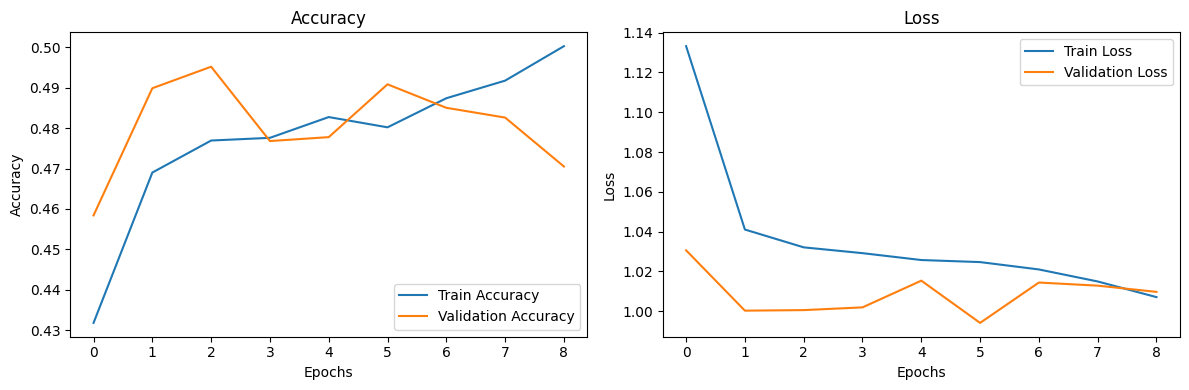

In [7]:
# --- Train the Model ---
epochs = 9 # Start with a reasonable number, tune later
batch_size = 64

history = model.fit(
    [X_home_train, X_away_train], # Pass inputs as a list
    y_train_encoded,
    validation_data=([X_home_val, X_away_val], y_val_encoded),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=class_weight_dict,
    verbose=1, # Show progress
)

# --- Evaluate the Model ---
test_loss, test_acc = model.evaluate(
    [X_home_test, X_away_test], y_test_encoded, verbose=1
)
print(f"\nTest Accuracy: {test_acc:.4f}")

# --- Predictions and Classification Report ---
y_pred_probs = model.predict([X_home_test, X_away_test])
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure y_test is the original class labels (0, 1, 2)
print(
    classification_report(
        y_test, y_pred, target_names=["Loss", "Draw", "Win"]
    )
)

# --- Optional: Plot training history ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [104]:
def validate_with_odds(X_home_test, X_away_test, y_test, odds_bookies, min_score = [0.5, 0.4, 0.5]):
    total = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    correct = {
        "A": 0,
        "D": 0,
        "H": 0
    }
    
    selected_info = {
        "A": [],
        "D": [],
        "H": []
    }
    odds = {
        "A": 0,
        "D": 0,
        "H": 0
    }

    odds_all = {
        "A": 0,
        "D": 0,
        "H": 0
    }

    correct_all = {
        "A": 0,
        "D": 0,
        "H": 0
    }

    total_all = 0

    
    y_probs = model.predict([X_home_test, X_away_test], verbose=0)
    pred = np.argmax(y_probs, axis=1)
    print(y_probs)
    print(odds_bookies)
    print(y_test)
    print(pred)

    for row_i in range(0, len(X_home_test)): 
        if pred[row_i] == y_test[row_i]:
            if pred[row_i] == 0:
                correct_all["A"] += 1
                odds_all["A"] += 1
            elif pred[row_i] == 1:
                correct_all["D"] += 1
                odds_all["D"] += 1
            else:
                correct_all["H"] += 1
                odds_all["H"] += 1
        total_all += 1

    for row_i in range(0,len(X_home_test)):
        if pred[row_i] == 0:
            if y_probs[row_i][0] > min_score[0]:
                total["A"] += 1
                if y_test[row_i] == 0:
                    correct["A"] += 1
                    odds["A"] += odds_bookies[row_i][2]
        elif pred[row_i] == 1:
            if y_probs[row_i][1] > min_score[1]:
                total["D"] += 1
                if y_test[row_i] == 1:
                    correct["D"] += 1
                    odds["D"] += odds_bookies[row_i][1]
        else:
            if y_probs[row_i][2] > min_score[2]:
                total["H"] += 1
                if y_test[row_i] == 2:
                    correct["H"] += 1
                    odds["H"] += odds_bookies[row_i][0]
    
    final_win = 0
    final_total = 0
    for key in odds.keys():
        print("-------------------")
        print("Total count:", total[key])
        print("Correct count:", correct[key])
        if (total[key] == 0):
            continue
        print("Prediction %:", correct[key] / total[key])
        print("Total odd won: ", odds[key] - total[key])
        print("Expected win per game: ", (odds[key] - total[key]) / total[key])
        final_win += odds[key] - total[key]
        final_total += total[key]
    print("----------FINAL---------")
    print("Total odd won: ", final_win)
    print("Expected win per game: ", final_win / final_total )
    print("Percentage of games: ", final_total / len(y_test))

    print("EXTRA")
    print("Odds: ", (odds_all["H"] + odds_all["D"] + odds_all["A"] - total_all)/total_all)
    print("Ratio: ", (correct_all["H"] + correct_all["D"] + correct_all["A"])/total_all)

In [105]:
validate_with_odds(X_home_test, X_away_test, y_test, odds[train_size + val_size :])

[[0.16317543 0.41081104 0.42601356]
 [0.3161012  0.38403368 0.29986516]
 [0.05381133 0.21922705 0.7269616 ]
 ...
 [0.5735833  0.2875876  0.13882907]
 [0.7437673  0.19088928 0.0653434 ]
 [0.08222597 0.49846205 0.41931197]]
[[ 2.15  3.25  3.5 ]
 [ 2.63  3.1   2.8 ]
 [ 1.2   7.   11.  ]
 ...
 [ 2.3   3.25  3.2 ]
 [ 5.5   4.    1.53]
 [ 1.48  4.75  6.  ]]
[2 0 2 ... 0 1 0]
[2 1 2 ... 0 0 1]
-------------------
Total count: 268
Correct count: 137
Prediction %: 0.5111940298507462
Total odd won:  -12.749999999999915
Expected win per game:  -0.04757462686567132
-------------------
Total count: 237
Correct count: 76
Prediction %: 0.3206751054852321
Total odd won:  45.05000000000007
Expected win per game:  0.1900843881856543
-------------------
Total count: 232
Correct count: 160
Prediction %: 0.6896551724137931
Total odd won:  5.360000000000127
Expected win per game:  0.023103448275862616
----------FINAL---------
Total odd won:  37.66000000000028
Expected win per game:  0.051099050203528194
Per